# Visualize Networkss

In [2]:
# Mathematical and Data Managment
import numpy as np
import pandas as pd

# Graph Managment
import graph_tool.all as gt
import networkx as nx
import utils.Functions as Fun
import utils.Segregation as Seg

# Data Visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Miscellaneous
from glob import glob
import random
import time
import multiprocessing as mp
import concurrent.futures

# Reload Utils
import importlib
importlib.reload(Seg)
importlib.reload(Fun)

/mnt/disk2/anaconda3/envs/gt_global/lib/python3.11/site-packages/graph_tool/draw/cairo_draw.py:1544: RuntimeWarning: Error importing Gtk module: ; GTK+ drawing will not work.
  warnings.warn(msg, RuntimeWarning)


<module 'utils.Functions' from '/mnt/disk2/lgomezt/Analysis-of-Tweets-During-the-2021-Social-Unrest/Code/utils/Functions.py'>

In [3]:
import os

In [4]:
os.listdir(r"../../../Data/Daily_graphs/Gephi/")

['2021-04-28_gephi.graphml']

In [5]:
g = nx.read_graphml("../../../Data/Daily_graphs/Gephi/2021-04-28_gephi.graphml")

In [6]:
g.number_of_nodes()

37112

In [7]:
g.number_of_edges()

198187

In [15]:
# Extract layout
# Extract layout information
layout_data = {}
for node_id, data in g.nodes(data=True):
    layout_data[node_id] = {
        'x': data.get('x', {}),
        'y': data.get('y', {}),
    }

# Get the positions from the layout data
pos = {node: (data['x'], data['y']) for node, data in layout_data.items()}

In [37]:
# Create a list of node colors based on 'Political Affiliation' attribute
pa = [data['Political Affiliation'] for node_id, data in g.nodes(data=True)]
color_map = {
    'Centro': "red", 
    'Derecha': "blue", 
    'Izquierda': "green", 
    'No Retweets': 'purple', 
}

node_colors = [color_map.get(i, 'gray') for i in pa]

# Create a list of node sizes based on 'size' attribute
node_sizes = [data['size'] for node_id, data in g.nodes(data=True)]

(-27991.626075, 28223.177075, -28286.423525, 31132.233025000016)

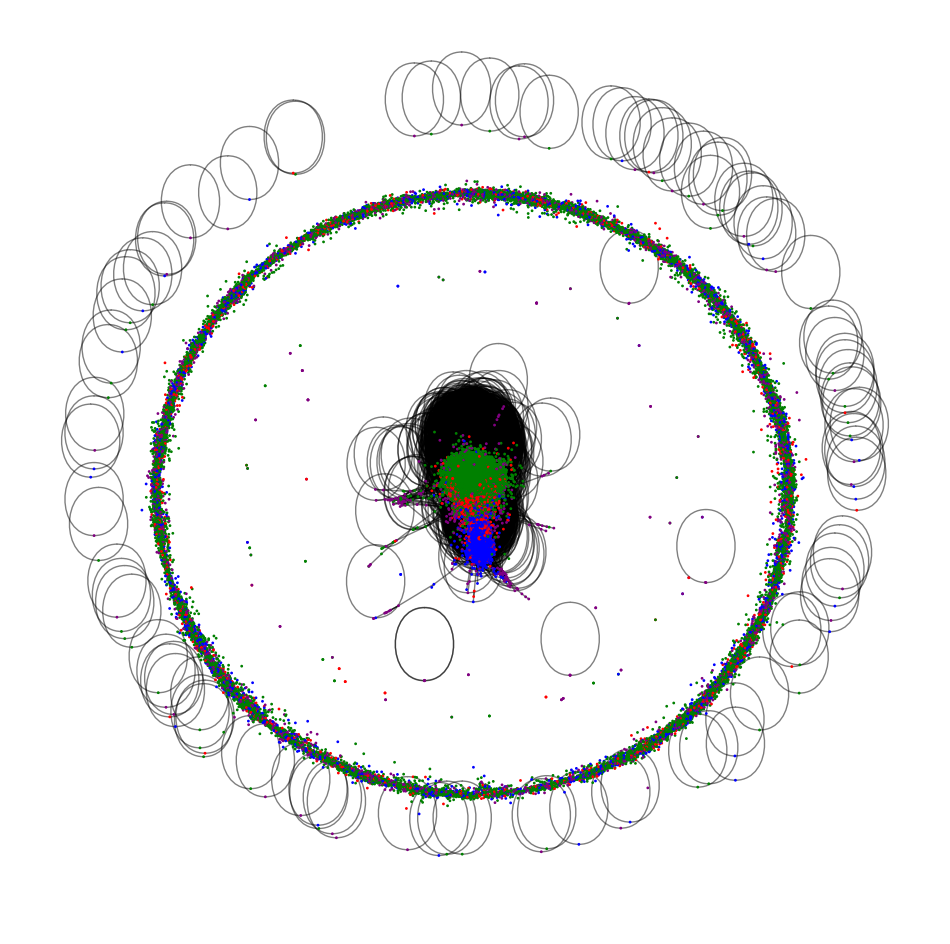

In [39]:
plt.figure(figsize = (12, 12)) 

# Draw nodes with specified size and color
nx.draw_networkx_nodes(g, pos, node_size = node_sizes, node_color = node_colors)

# Draw edges
nx.draw_networkx_edges(g, pos, alpha = 0.5, arrows = False)

plt.axis('off')

### Force Atlas 2

In [ ]:
from forceatlas2 import forceatlas2_networkx_layout

In [14]:
ls = []
files = glob('/mnt/disk2/Data/3_Day_Graphs/*.graphml')

for file in files:
    g = gt.load_graph(file)
    N = g.num_vertices()
    ls.append((file,N))

sorted_ls = sorted(ls, key=lambda x: x[1], reverse=True)
sorted_files = [g[0] for g in sorted_ls]

In [37]:
# PASO 0
def initial_pos():
    master_id = pd.read_csv('/mnt/disk2/Data/3_Day_Graphs/Nodes.csv', sep = ';')
    pos = {i: (random.random(), random.random()) for i in master_id['Idx in Graph']}
    return pos

# PASO 1
def read_graph(file, fraction):
    g = gt.load_graph(file)
    g = Fun.fraction_graph(g,fraction)
    date = file.split('/')[-1].split('.')[0].split('_')[-1]    
    g_nx = Fun.to_networkx(g)
    g_nx = g_nx.to_undirected()
    return g_nx, date

# PASO 2.1
def colors_list(g_nx):
    nodes = g_nx.nodes(data=True)
    colors = [node[1]['Color'] for node in nodes]
    return colors

# PASO 2.2
def node_size(g_nx):
    node_degree = [g_nx.degree(node) for node in g_nx.nodes]
    return node_degree

# PASO 2.3
def self_loops(g_nx):
    self_loops = list(nx.selfloop_edges(g_nx))
    non_self_loop_edges = [(u, v) for u, v in g_nx.edges() if (u, v) not in self_loops and (v, u) not in self_loops]
    return non_self_loop_edges

# PASO 3
def layout(g_nx, pos, iter):
    fa2_layout = forceatlas2_networkx_layout(g_nx, pos, niter=iter)
    return fa2_layout

# PASO 4
def draw(g_nx, fa2_layout, node_degree, colors_list, non_self_loop_edges, file):
    fig, ax = plt.subplots(figsize=(18, 12))

    nx.draw_networkx_nodes(g_nx,
                                fa2_layout,
                                node_size = node_degree,
                                node_color = colors_list,
                                edgecolors=(0,0,0,0.1),
                                ax = ax)

    #nx.draw_networkx_edges(g_nx, fa2_layout, edgelist=non_self_loop_edges, alpha=0.1, ax=ax)
    plt.axis('off')
    filename = f'starting_{file}'
    plt.savefig(f'../Results/3_Day_graphs_Viz/{filename}.png')
    plt.close()
    return filename

In [38]:
if __name__ == '__main__':
    
    start = time.perf_counter()
    # PASO 0
    random.seed(427)
    pos = initial_pos()
    iteration=[]
    for i in range(1, 41, 5):     
        def Program(file):
            try:
                start = time.perf_counter()
                # PASO 1
                random.seed(427)
                g_nx, date = read_graph(file,i)
                    
                # PASO 2
                colors = colors_list(g_nx)
                size = node_size(g_nx)
                non_self_loop_edges = self_loops(g_nx)
                    
                # PASO 3 YUCA
                fa2_layout = layout(g_nx, pos, 100)
                    
                # PASO 4
                filename = draw(g_nx, fa2_layout, size, colors, non_self_loop_edges, date)
                #print(f'Done with {filename}')
                
                finish = time.perf_counter()
                return filename
        
            except Exception as e:
                # Log the exception or handle it appropriately
                print(f"Exception in parallel task: {e}")
        
        with concurrent.futures.ProcessPoolExecutor() as executor:
            layouts = executor.map(Program, sub_files)
        
        finish = time.perf_counter()
        iteration.append(finish-start)
        print(f'Finished in {round(finish-start, 2)} second(s)')

Finished in 11.92 second(s)
Finished in 271.75 second(s)
Finished in 1196.18 second(s)


KeyboardInterrupt: 